In [6]:
import json
import pandas as pd
from pathlib import Path
pd.set_option('max_colwidth',300)
import seaborn as sns
from matplotlib import pyplot as plt

# Get Source Code from Code Search Net

This notebook originally comes from code search net https://github.com/github/CodeSearchNet

In [2]:
!wget https://s3.amazonaws.com/code-search-net/CodeSearchNet/v2/python.zip
!wget https://s3.amazonaws.com/code-search-net/CodeSearchNet/v2/java.zip

--2019-06-14 01:05:08--  https://s3.amazonaws.com/code-search-net/CodeSearchNet/v2/python.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.184.77
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.184.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 218813834 (209M) [application/zip]
Saving to: ‘python.zip’

python.zip          100%[===================>] 208.68M  63.9MB/s    in 3.3s    

2019-06-14 01:05:11 (63.9 MB/s) - ‘python.zip’ saved [218813834/218813834]



In [3]:
!unzip python.zip
!unzip java.zip

Archive:  python.zip
   creating: python/
   creating: python/final/
   creating: python/final/jsonl/
   creating: python/final/jsonl/valid/
  inflating: python/final/jsonl/valid/python_valid_0.jsonl.gz  
   creating: python/final/jsonl/test/
  inflating: python/final/jsonl/test/python_test_0.jsonl.gz  
   creating: python/final/jsonl/train/
  inflating: python/final/jsonl/train/python_train_7.jsonl.gz  
  inflating: python/final/jsonl/train/python_train_6.jsonl.gz  
  inflating: python/final/jsonl/train/python_train_12.jsonl.gz  
  inflating: python/final/jsonl/train/python_train_13.jsonl.gz  
  inflating: python/final/jsonl/train/python_train_0.jsonl.gz  
  inflating: python/final/jsonl/train/python_train_1.jsonl.gz  
  inflating: python/final/jsonl/train/python_train_4.jsonl.gz  
  inflating: python/final/jsonl/train/python_train_5.jsonl.gz  
  inflating: python/final/jsonl/train/python_train_9.jsonl.gz  
  inflating: python/final/jsonl/train/python_train_8.jsonl.gz  
  inflating: p

In [ ]:
# decompress gzip file
!gzip -d python/final/jsonl/test/python_test_0.jsonl.gz
!gzip -d python/final/jsonl/test/python_valid_0.jsonl.gz
!gzip -d java/final/jsonl/test/java_test_0.jsonl.gz
!gzip -d java/final/jsonl/valid/java_valid_0.jsonl.gz

To make analysis of this dataset easier, we can load all of the data into a pandas dataframe: 

In [3]:
columns_long_list = ['repo', 'path', 'url', 'code', 
                     'code_tokens', 'docstring', 'docstring_tokens', 
                     'language', 'partition']

columns_short_list = ['code_tokens', 'docstring_tokens', 
                      'language', 'partition']

def jsonl_list_to_dataframe(file_list, columns=columns_long_list):
    """Load a list of jsonl.gz files into a pandas DataFrame."""
    return pd.concat([pd.read_json(f, 
                                   orient='records', 
                                   compression='gzip',
                                   lines=True)[columns] 
                      for f in file_list], sort=False)

## Load python and java dataset

In [3]:
python_files =['python/final/jsonl/test/python_test_0.jsonl.gz', 'python/final/jsonl/valid/python_valid_0.jsonl.gz']
pydf = jsonl_list_to_dataframe(python_files)

In [4]:
java_files =['java/final/jsonl/test/java_test_0.jsonl.gz', 'java/final/jsonl/valid/java_valid_0.jsonl.gz']
javadf = jsonl_list_to_dataframe(java_files)

## Deduplicate (remove the code samples used in CuBERT and CodeBERT pre-training). 

In [4]:
cubert_files_py  = sorted(Path('Cubert Python/').glob('*'))
cubert_files_py[:3]

[WindowsPath('../../PLasNL/data/Cubert Python/20200621_Python_github_python_minus_ethpy150open_deduplicated_manifest_manifest.jsontxt-00000-of-00041'),
 WindowsPath('../../PLasNL/data/Cubert Python/20200621_Python_github_python_minus_ethpy150open_deduplicated_manifest_manifest.jsontxt-00001-of-00041'),
 WindowsPath('../../PLasNL/data/Cubert Python/20200621_Python_github_python_minus_ethpy150open_deduplicated_manifest_manifest.jsontxt-00002-of-00041')]

In [5]:
cubert_files_java  = sorted(Path('Cubert Java/').glob('*'))
cubert_files_java[:3]

[WindowsPath('../../PLasNL/data/Cubert Java/manifest.jsontxt-00000-of-00056'),
 WindowsPath('../../PLasNL/data/Cubert Java/manifest.jsontxt-00001-of-00056'),
 WindowsPath('../../PLasNL/data/Cubert Java/manifest.jsontxt-00002-of-00056')]

In [5]:
cubertdf_py = pd.concat([pd.read_json(f, 
                                   orient='records', 
                                   lines=True)[["repository","filepath","license","id","url"]] 
                      for f in cubert_files_py], sort=False)

In [6]:
cubertdf_java = pd.concat([pd.read_json(f, 
                                   orient='records', 
                                   lines=True)[["repository","filepath","license","id","url"]] 
                      for f in cubert_files_java], sort=False)

In [6]:
print(cubertdf_py["repository"].count())
cubertdf_py.head(3)

7447860


,repository,filepath,license,id,url
0,bndl/elastic,bndl_elastic/tests/test_index.py,apache-2.0,cad86d9a5a1f1ae2822bc8eddec530e258eb05a2,https://api.github.com/repos/bndl/elastic/git/blobs/cad86d9a5a1f1ae2822bc8eddec530e258eb05a2
1,luosch/leetcode,python/Basic Calculator II.py,mit,3a3c7d7cef99ca7b00e5c41f506edb7d8de78c54,https://api.github.com/repos/luosch/leetcode/git/blobs/3a3c7d7cef99ca7b00e5c41f506edb7d8de78c54
2,Tony-Tsoi/proj-euler-ans,problems/prob014.py,mit,261310b3f77ef7396fd622c3d40b935b72ab5e6f,https://api.github.com/repos/Tony-Tsoi/proj-euler-ans/git/blobs/261310b3f77ef7396fd622c3d40b935b72ab5e6f


In [7]:
print(cubertdf_java["repository"].count())
cubertdf_java.head(3)

15866056


,repository,filepath,license,id,url
0,telestack/Floodlight,src/main/java/net/floodlightcontroller/forwarding/ForwardingPR.java,apache-2.0,5ceb3e290177bf161b2e2995c83c31ac4958888d,https://api.github.com/repos/telestack/Floodlight/git/blobs/5ceb3e290177bf161b2e2995c83c31ac4958888d
1,kd0kfo/webfs,java/core/src/main/java/com/davecoss/uploader/auth/AuthHash.java,gpl-3.0,6ee82be1882f45b7c79a889d04a5406fc7f64ce3,https://api.github.com/repos/kd0kfo/webfs/git/blobs/6ee82be1882f45b7c79a889d04a5406fc7f64ce3
2,Lecrayen/PlatinumMMO,com/gmail/Lecrayen/Platinum/MMO/Commands/Portal/PortalList.java,mit,353fdbce6bff7dc8256c50375cae609b5e5c5f62,https://api.github.com/repos/Lecrayen/PlatinumMMO/git/blobs/353fdbce6bff7dc8256c50375cae609b5e5c5f62


In [9]:
deduplicated_py=pydf[~pydf["repo"].isin(cubertdf_py["repository"])]

In [8]:
deduplicated_java=javadf[~javadf["repo"].isin(cubertdf_java["repository"])]

# convert dataframe to lists and save to file

In [33]:
data_full = []
for index, row in deduplicated_py.iterrows():
    data_full.append({"code": row['code'], 'repo': row['repo'], 'path': row['path'], 'url': row['url'], 'docstring': row['docstring']})
data_code_only = [c  for c in deduplicated_py["code"].tolist()]

with open('deduplicated_python_full.pickle', 'wb') as f:
    pickle.dump(data_full, f)

with open('deduplicated_python_code.pickle', 'wb') as f:
    pickle.dump(data_code_only, f)

In [11]:
data_full = []
for index, row in deduplicated_java.iterrows():
    data_full.append({"code": row['code'], 'repo': row['repo'], 'path': row['path'], 'url': row['url'], 'docstring': row['docstring']})
data_code_only = [c  for c in deduplicated_java["code"].tolist()]

with open('deduplicated_java_full.pickle', 'wb') as f:
    pickle.dump(data_full, f)

with open('deduplicated_java_code.pickle', 'wb') as f:
    pickle.dump(data_code_only, f)
    
# write to seperate files for java ast parser
for i in range(len(data_code_only)):
    with open("Java AST Parser/data/"+str(i)+".txt", "w", encoding='utf8') as f:
        f.write(data_code_only[i])

# generate dataset statistics

In [3]:
# dataset statistics

def get_relns(dataset):
    relns = set()
    for example in dataset:
        for reln in example["relns"].keys():
            relns.add(reln)
    relns = list(relns)
    relns.sort()
    return relns

def get_relns_and_count(dataset):
    count = {}
    for reln in get_relns(dataset):
        count[reln] = 0
    for example in dataset:
        for reln in example["relns"].keys():
            count[reln] += len(example["relns"][reln])
    return count

with open("../CodeSyntax/CodeSyntax_python.json", 'r') as f:
    dataset = json.load(f)
with open("../CodeSyntax/CodeSyntax_java.json", 'r') as f:
    dataset_java = json.load(f)
count = get_relns_and_count(dataset)
count_java = get_relns_and_count(dataset_java)
relns = list(count.keys())
relns.extend(list(count_java.keys()))
relns = list(set(relns))
relns.sort()
total_count = 0
total_count_java = 0
for reln in relns:
    line = reln + " & " 
    line += str(count[reln]) if reln in count else "/"
    if reln in count: total_count += count[reln]
    line += " & " 
    line += str(count_java[reln]) if reln in count_java else "/"
    if reln in count_java: total_count_java += count_java[reln]
    line += " & & & \\\\"
    print(line)
print("total_count", total_count, "total_count_java", total_count_java)

Assign:target->value & 78482 & 13384 & & & \\
Attribute:value->attr & 158797 & 84215 & & & \\
AugAssign:target->value & 3150 & / & & & \\
BinOp:left->right & 26035 & / & & & \\
BoolOp:value->value & 5783 & / & & & \\
Call:args->keywords & 9256 & / & & & \\
Call:func->args & 110949 & 50890 & & & \\
Call:func->keywords & 16274 & / & & & \\
Compare:left->comparator & 25852 & / & & & \\
Dict:key->value & 7787 & / & & & \\
DictComp:key->generator & 359 & / & & & \\
DictComp:key->value & 359 & / & & & \\
DictComp:value->generator & 359 & / & & & \\
Do:body->test & / & 38 & & & \\
Do:do->body & / & 45 & & & \\
Do:do->test & / & 38 & & & \\
For:for->body & 8704 & 1864 & & & \\
For:for->initializers & / & 1650 & & & \\
For:for->iter & 8704 & / & & & \\
For:for->target & 8704 & / & & & \\
For:for->test & / & 1296 & & & \\
For:for->updaters & / & 1682 & & & \\
For:initializers->body & / & 1781 & & & \\
For:initializers->test & / & 1286 & & & \\
For:initializers->updaters & / & 1670 & & & \\
For:i

In [4]:
# offset distribution plot

with open("../CodeSyntax/CodeSyntax_python.json", 'r') as f:
    dataset = json.load(f)
with open("../CodeSyntax/CodeSyntax_java.json", 'r') as f:
    dataset_java = json.load(f)

reln_to_offset = [{}, {}]
for i, d in [(0, dataset), (1, dataset_java)]:
    relns = get_relns(d)
    reln_to_offset[i]["start"] = []
    reln_to_offset[i]["end"] = []
    for reln in relns:
        sum1, sum2, count = 0, 0, 0
        for example in d:
            if reln in example["relns"]:
                labels = example["relns"][reln]
                for dep_idx, head_start_idx, head_end_idx in labels:
                    sum1 += head_start_idx - dep_idx
                    sum2 += head_end_idx - dep_idx
                    count += 1
        reln_to_offset[i]["start"].append(sum1/count)
        reln_to_offset[i]["end"].append(sum2/count)
    reln_to_offset[i]["start"].sort()
    reln_to_offset[i]["end"].sort()

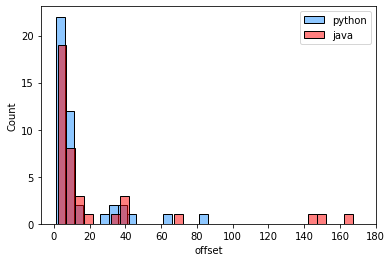

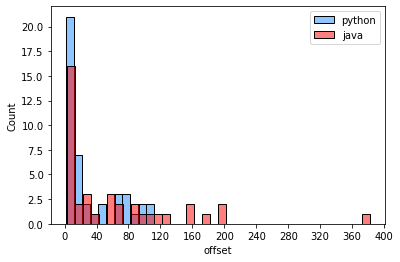

In [8]:
fig, ax = plt.subplots(figsize=(8,5))
sns.histplot(reln_to_offset[0]["start"], binwidth=5, color="dodgerblue", label="python", alpha=0.5)
sns.histplot(reln_to_offset[1]["start"], binwidth=5, color="red", label="java", alpha=0.5)
plt.xlabel("offset")
plt.legend()
fig.set_size_inches(6., 4)
plt.xticks(list(range(0, 200, 20)))
fig.savefig("../data/figures/offset_distribution_start.pdf", bbox_inches='tight')
plt.show()

fig, ax = plt.subplots(figsize=(8,5))
sns.histplot(reln_to_offset[0]["end"], binwidth=10, color="dodgerblue", label="python", alpha=0.5)
sns.histplot(reln_to_offset[1]["end"], binwidth=10, color="r", label="java", alpha=0.5)
plt.xlabel("offset")
plt.legend()
fig.set_size_inches(6., 4)
plt.xticks(list(range(0, 401, 40)))
fig.savefig("../data/figures/offset_distribution_end.pdf", bbox_inches='tight')
plt.show()
